In [1]:
!pip install -e ../.

Obtaining file:///home
ERROR: file:///home does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [2]:
import sys
sys.path.insert(0, '../')  


In [3]:
%pwd


'/home/mayank'

In [4]:
import cvaei
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torch import nn, optim
from cvaei.examples.villar import Villar
from cvaei.models.conv_cvae import CNN_CVAE
import multiprocessing as mp


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.is_available())
print(torch.version.cuda)



Using device: cuda
True
12.1


In [5]:
villar = Villar()
mp.set_start_method('spawn')
train_theta_norm, train_data_norm, theta_normalizer, data_normalizer, val_theta_norm, val_data_norm = villar.prepare_data(10000, scale = True)
observed_data = villar.observed_data()
#villar.check_normalizer()

Generating data...


KeyboardInterrupt: 

In [ ]:
train_data_norm[3]

tensor([[0.0000e+00, 2.1211e-02, 1.0243e-01, 2.4470e-01, 4.2266e-01, 6.2338e-01,
         7.9203e-01, 4.3145e-01, 2.4728e-01, 1.9555e-01, 1.2933e-01, 1.4434e-01,
         1.3658e-01, 1.3968e-01, 1.4744e-01, 1.2830e-01, 1.0140e-01, 1.1588e-01,
         1.3813e-01, 9.5706e-02, 1.3295e-01, 2.2297e-01, 3.2023e-01, 4.6042e-01,
         6.1562e-01, 8.0652e-01, 8.0807e-01, 3.6989e-01, 1.9917e-01, 1.4847e-01,
         1.2985e-01, 1.2364e-01, 1.1381e-01, 1.2054e-01, 8.5877e-02, 1.0812e-01,
         1.3554e-01, 1.1226e-01, 1.2312e-01, 1.3502e-01, 1.2261e-01, 1.2830e-01,
         1.1278e-01, 9.7775e-02, 1.2830e-01, 8.5360e-02, 7.0874e-02, 1.3451e-01,
         1.8055e-01, 2.7677e-01, 3.9783e-01, 5.4992e-01, 7.3306e-01, 9.0533e-01,
         5.6234e-01, 2.8091e-01, 2.0072e-01, 1.3813e-01, 1.2985e-01, 1.2468e-01,
         1.1381e-01, 1.4020e-01, 1.3399e-01, 1.3916e-01, 1.2209e-01, 1.1795e-01,
         1.0502e-01, 9.6741e-02, 1.1226e-01, 9.7258e-02, 8.3808e-02, 1.2519e-01,
         1.6917e-01, 2.4780e

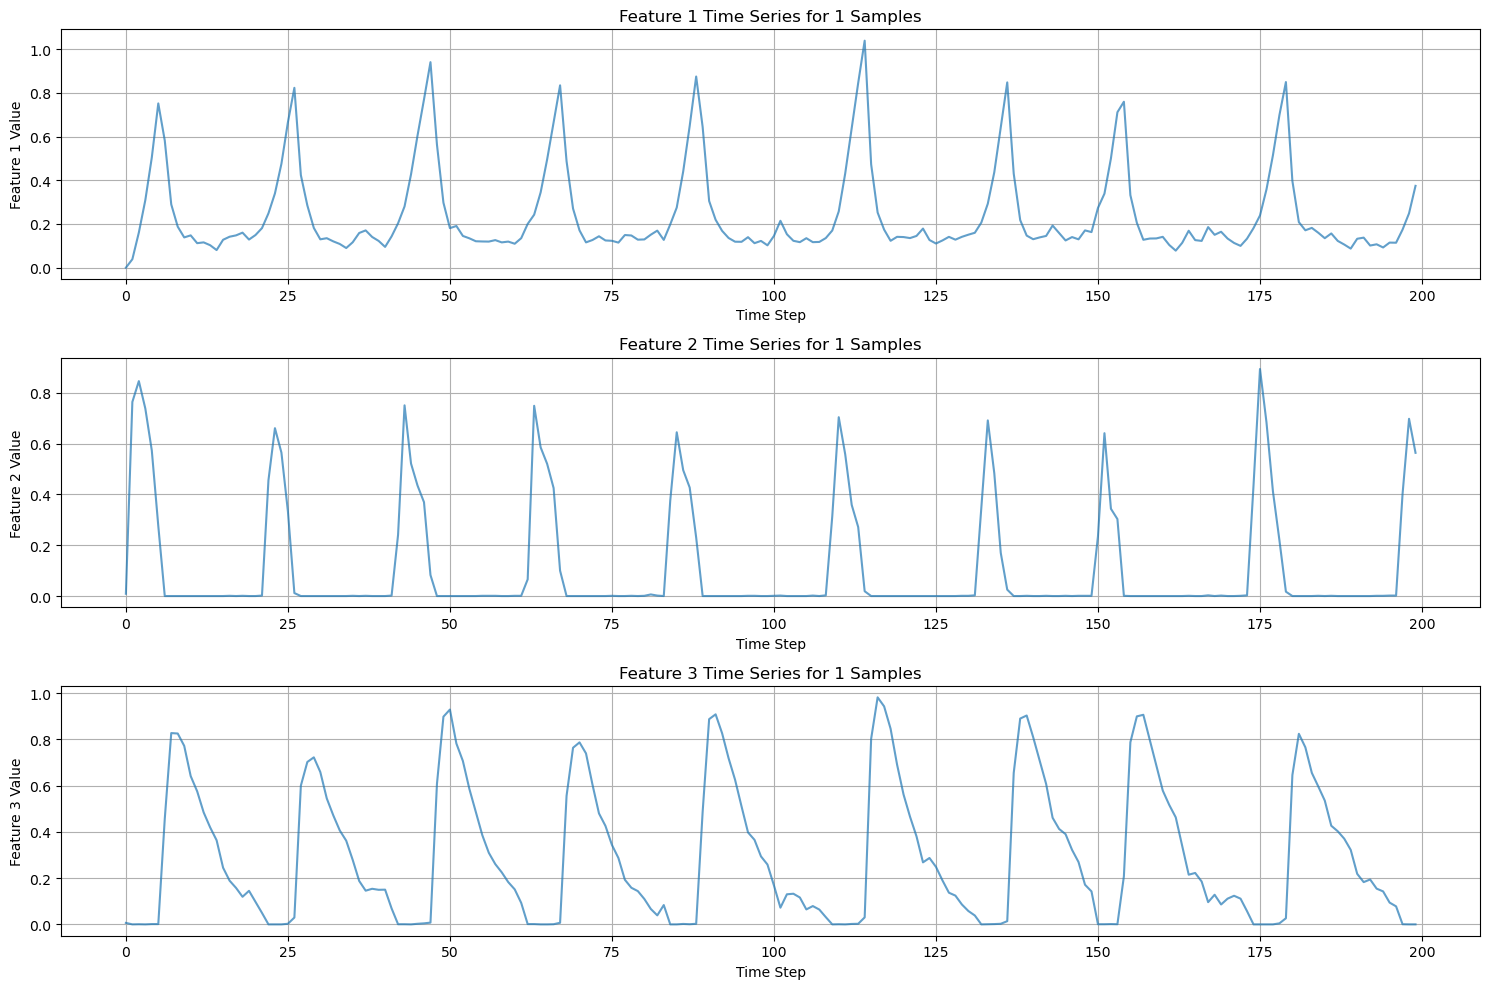

In [ ]:
villar.plot_observation(observed_data)

# Initialise the Model

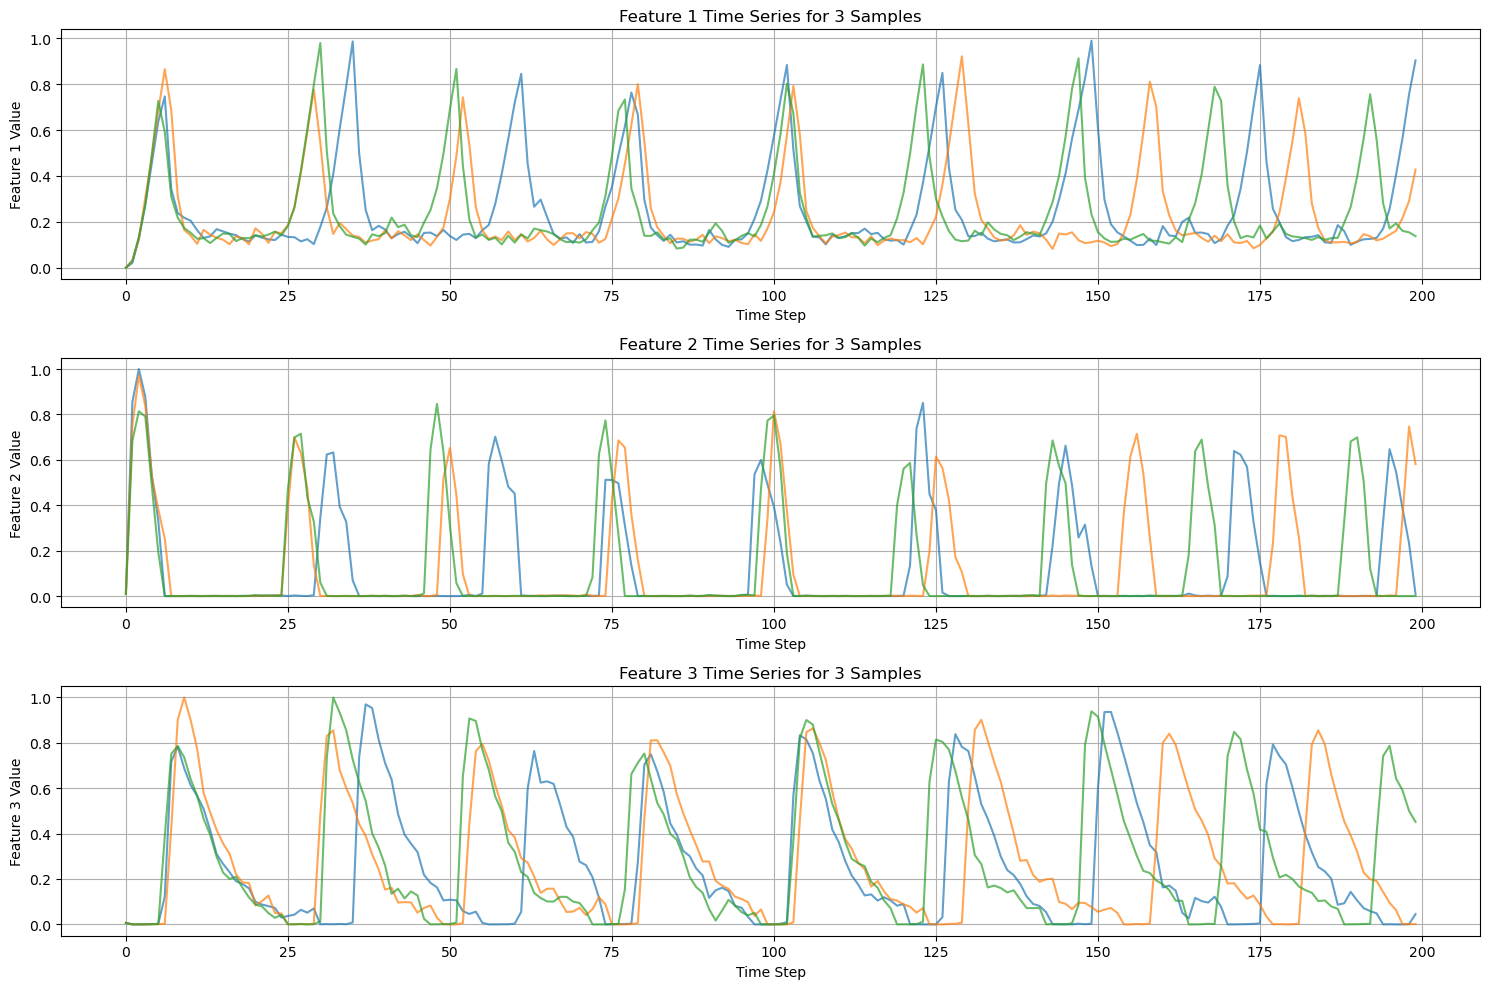

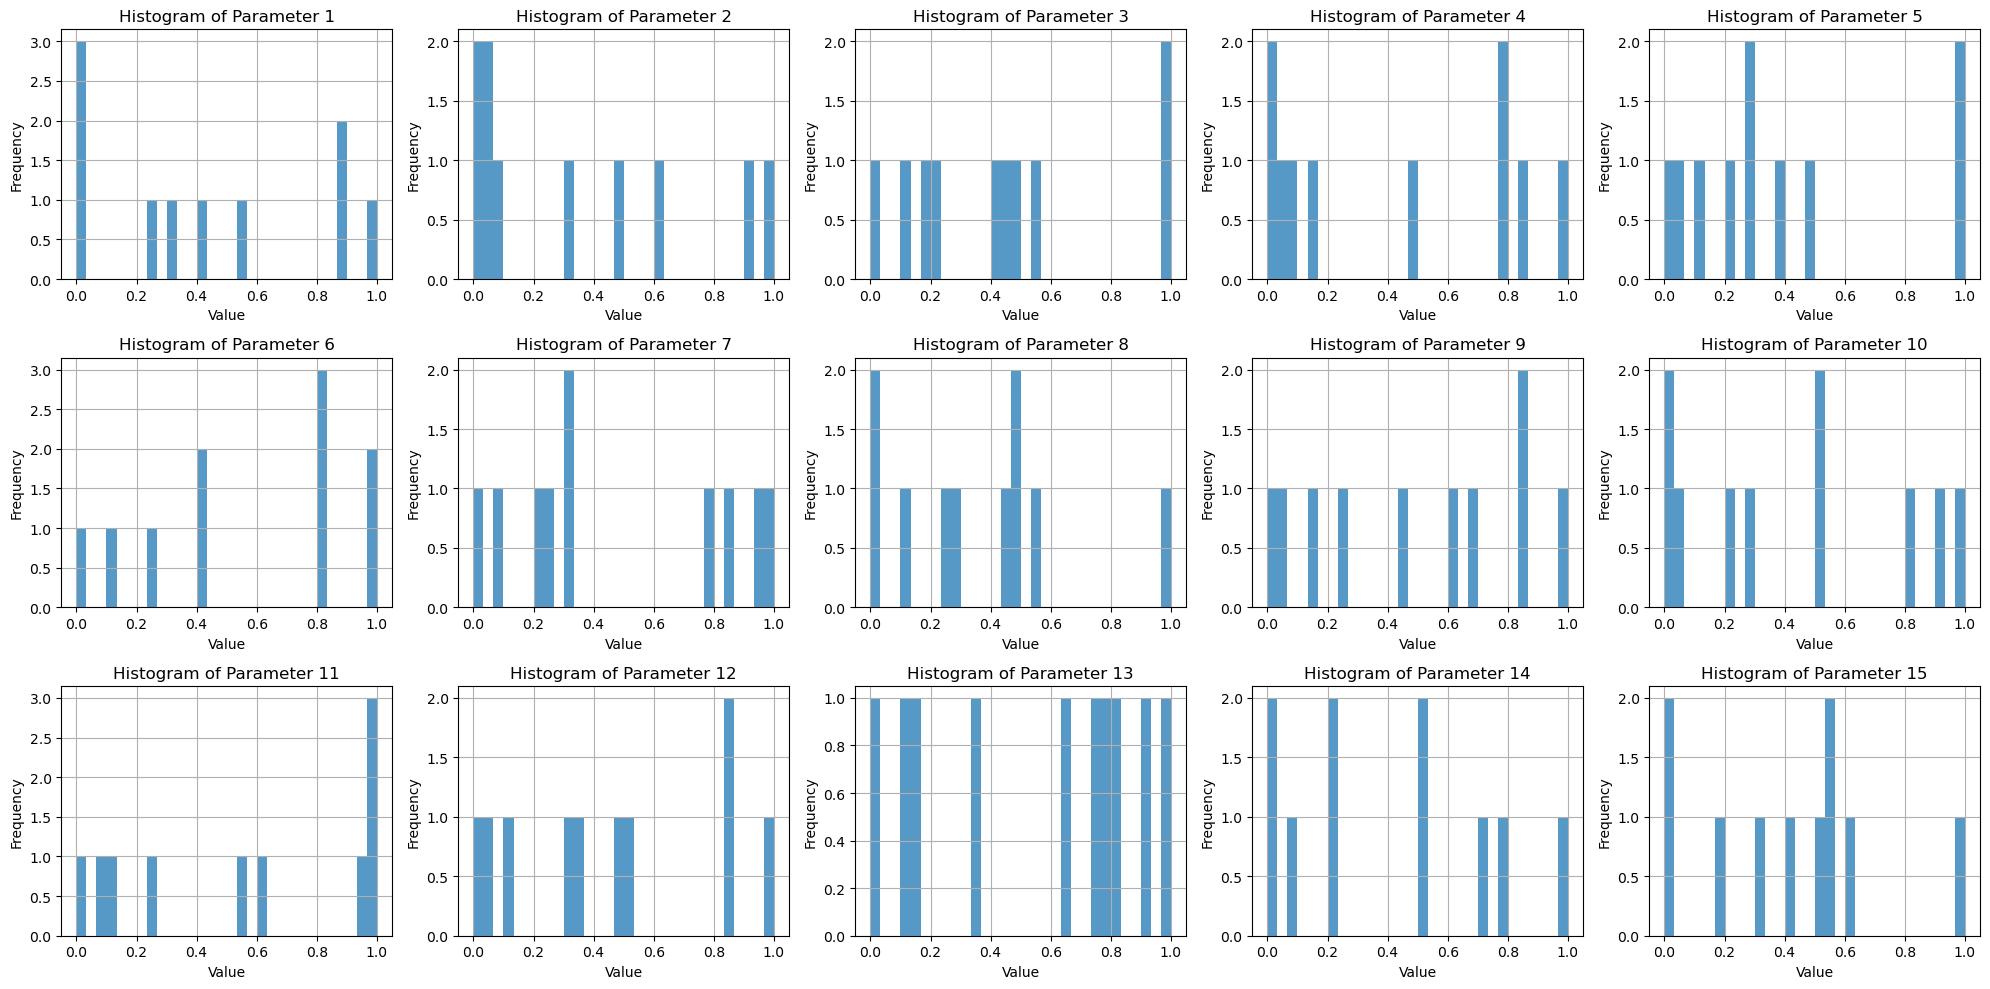

In [ ]:
villar.plot_observation(train_data_norm, num_samples =3)
villar.plot_prior(train_theta_norm)

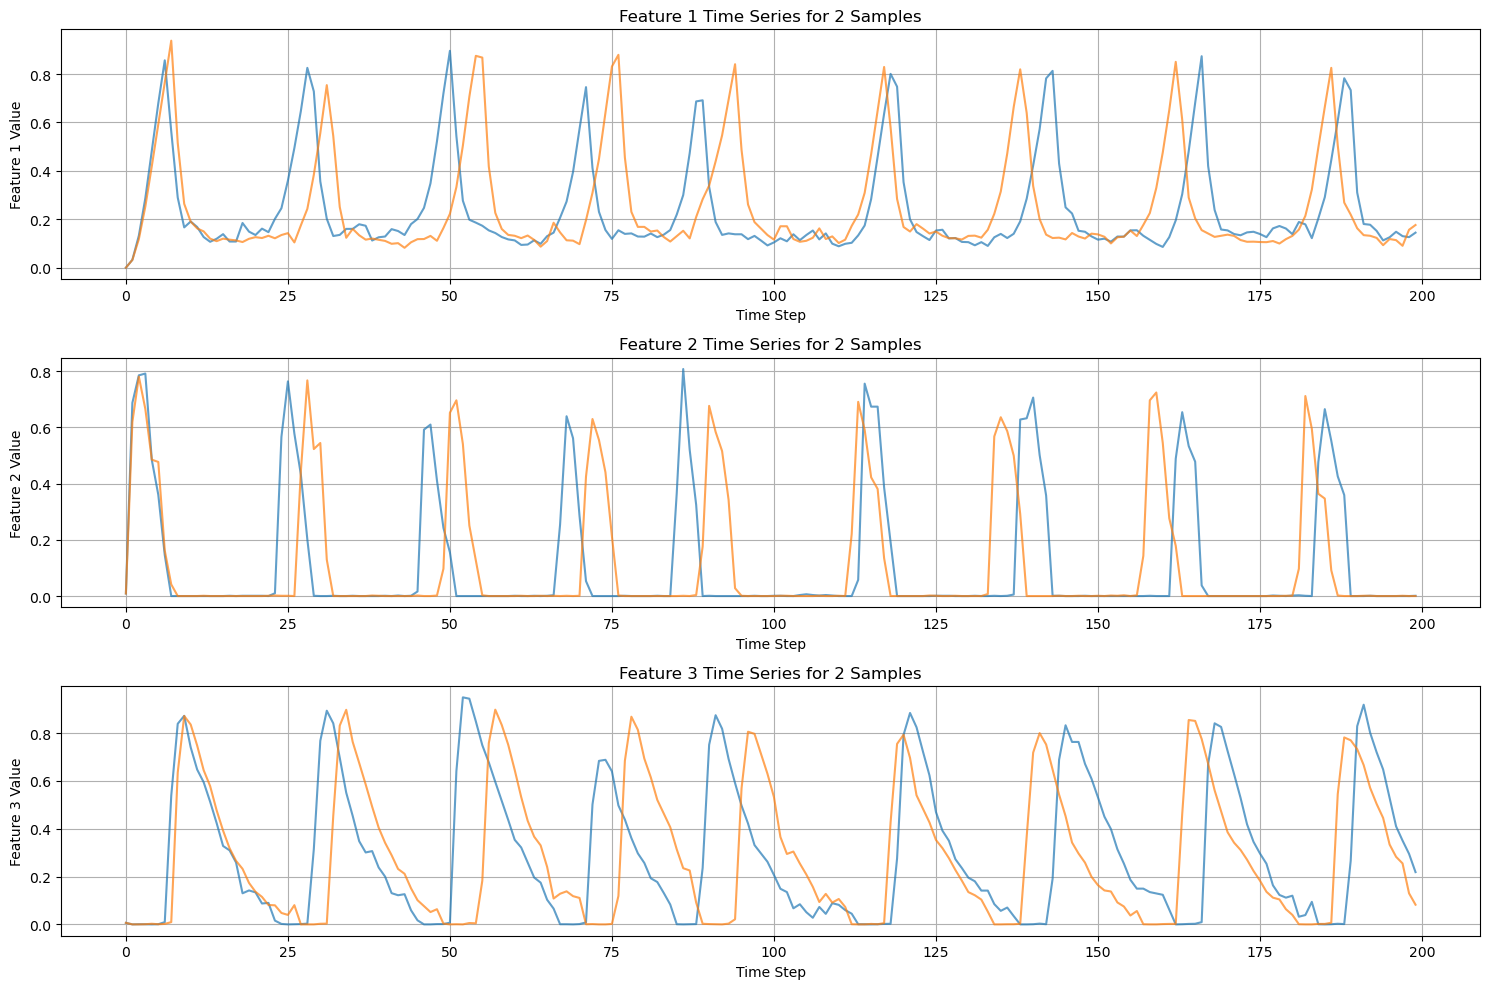

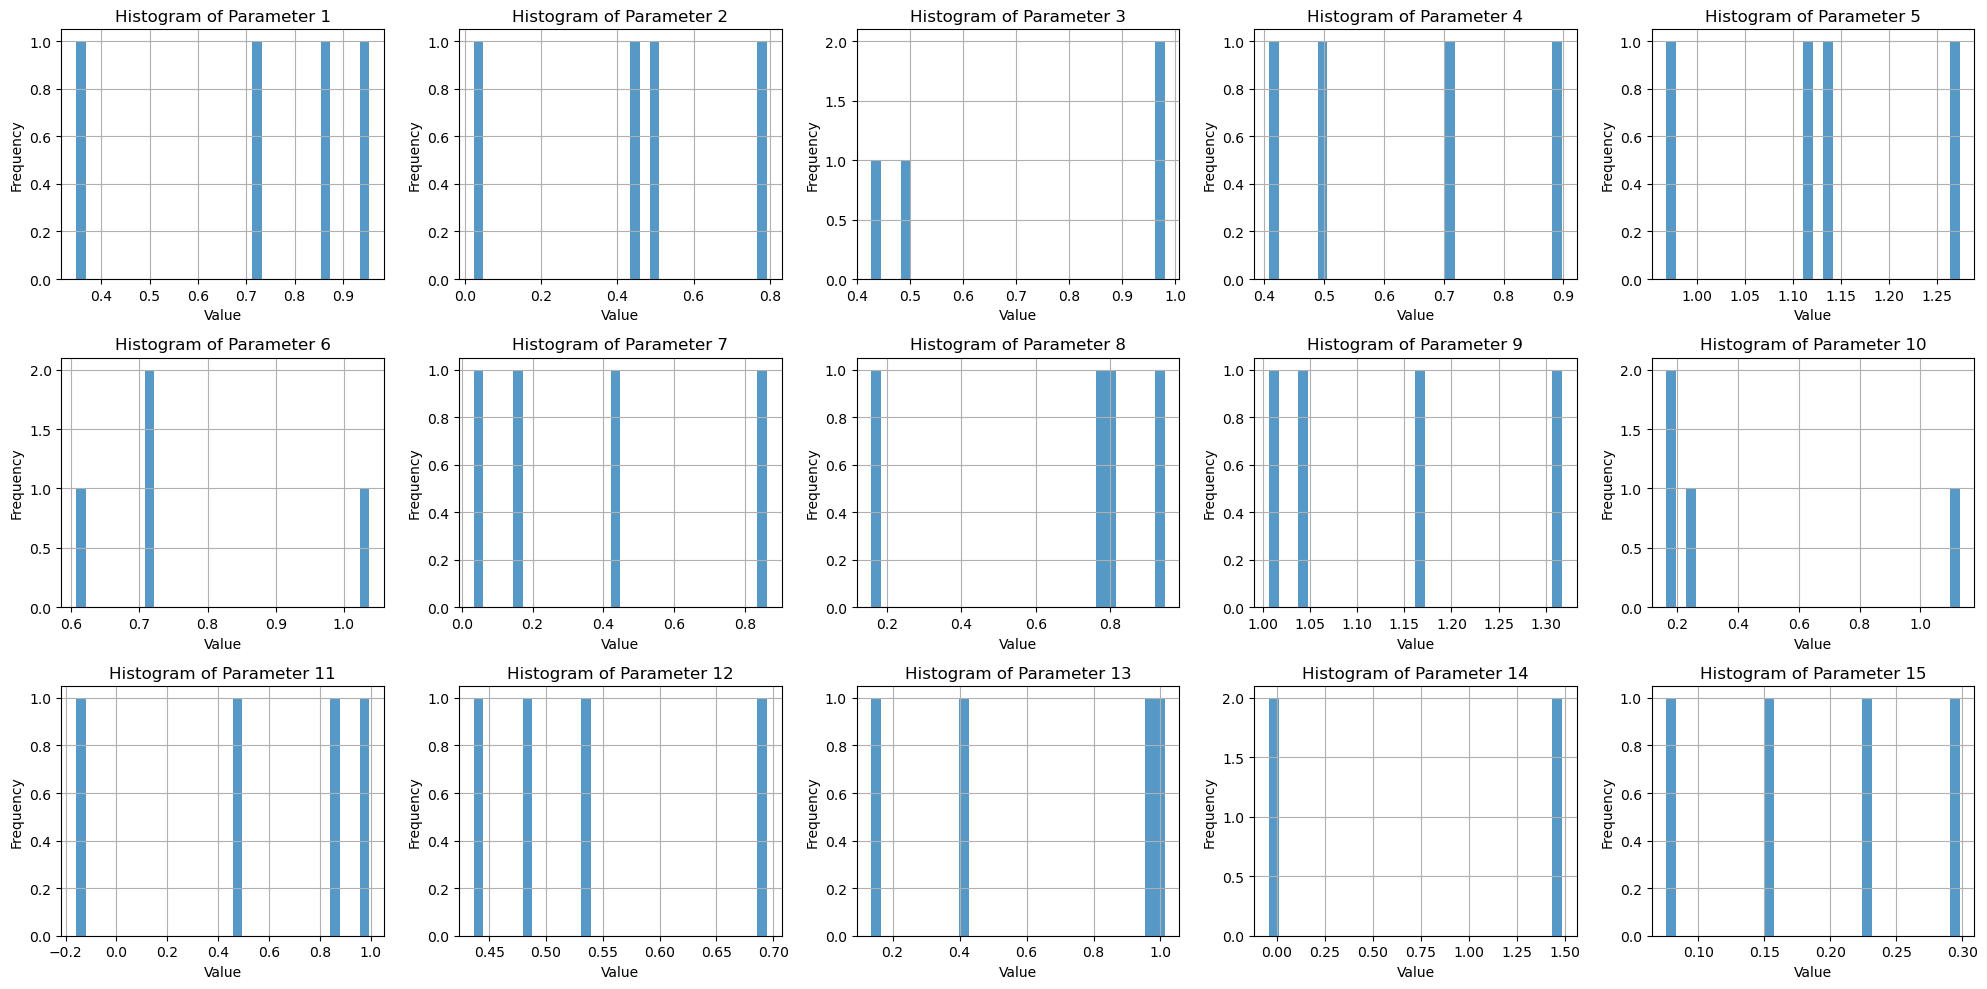

In [ ]:
villar.plot_observation(val_data_norm, num_samples =2)
villar.plot_prior(val_theta_norm)

# Define the CVAE Network

In [ ]:
# Instantiate the CNN_CVAE model
input_dim = 15  # Example input dimension
latent_dim = 200  # Example latent space dimension
conditional_dim = 3  # Based on Nx3x200 conditional input
encoder_hidden_dims = [512,512]  # Example hidden dimensions for the encoder
sequence_length = 200  # Length of sequences in the conditional input
conv_output_channels = [64, 32]  # Channels in each Conv1D layer for the decoder
kernel_sizes = [3, 3]  # Kernel sizes for the Conv1D layers in the decoder
output_channels = 3  # Matching the original conditional input's channels



network = CNN_CVAE(
    input_dim=input_dim,
    latent_dim=latent_dim,
    conditional_dim=conditional_dim,
    encoder_hidden_dims=encoder_hidden_dims,
    decoder_hidden_dims=[],  # Assuming this is not used in the provided structure
    sequence_length=sequence_length,
    conv_output_channels=conv_output_channels,
    kernel_sizes=kernel_sizes,
    activation_fn= nn.LeakyReLU(0.1),
    w_recon=1.0,
    w_misfit=1.0,
    kld=1.0
)

optimizer = optim.AdamW(network.parameters(), lr=1e-3)

train_dataset = TensorDataset(train_data_norm, train_theta_norm)
val_dataset = TensorDataset(val_data_norm, val_theta_norm)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
validation_loader = DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

print(network)

CNN_CVAE(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=15, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): LeakyReLU(negative_slope=0.1)
    )
    (fc_mean): Linear(in_features=512, out_features=200, bias=True)
    (fc_logvar): Linear(in_features=512, out_features=200, bias=True)
  )
  (decoder): CNN_Decoder(
    (fc_expand): Linear(in_features=200, out_features=200, bias=True)
    (conv_layers): ModuleList(
      (0): Conv1d(4, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (output_layer_1): Linear(in_features=6400, out_features=15, bias=True)
    (output_layer_2): Conv1d(32, 3, kernel_size=(1,), stride=(1,))
  )
)


In [ ]:
network.train_model(train_loader=train_loader,
                    validation_loader= validation_loader,
                    optimizer=optimizer,
                    epochs=20,
                    num_cycles = 1,
                    theta_normalizer=theta_normalizer,
                    data_normalizer=data_normalizer,
                    
                    patience=100)

Using GPU: NVIDIA RTX A5000 for training.
Epoch 1/20: Beta: 0.0, total_loss: 88.9327, recon_loss: 4.7804, misfit_loss: 84.1523, kl_div: 0.0000
Epoch 1/20 Validation: total_loss: 82.3163, recon_loss: 3.8217, misfit_loss: 78.4945, kl_div: 0.0000

Epoch 1: Validation loss improved to 20.57906532
Epoch 2/20: Beta: 0.1, total_loss: 77.4104, recon_loss: 2.0258, misfit_loss: 75.2835, kl_div: 0.1011
Epoch 2/20 Validation: total_loss: 72.8095, recon_loss: 2.4924, misfit_loss: 70.1511, kl_div: 0.1659

Epoch 2: Validation loss improved to 18.20236588
Epoch 3/20: Beta: 0.2, total_loss: 69.5836, recon_loss: 2.3256, misfit_loss: 67.0463, kl_div: 0.2116
Epoch 3/20 Validation: total_loss: 65.1345, recon_loss: 2.8411, misfit_loss: 62.0901, kl_div: 0.2033

Epoch 3: Validation loss improved to 16.28362656
Epoch 4/20: Beta: 0.3, total_loss: 62.5477, recon_loss: 3.1415, misfit_loss: 59.2046, kl_div: 0.2016
Epoch 4/20 Validation: total_loss: 57.8156, recon_loss: 2.9020, misfit_loss: 54.7608, kl_div: 0.1529


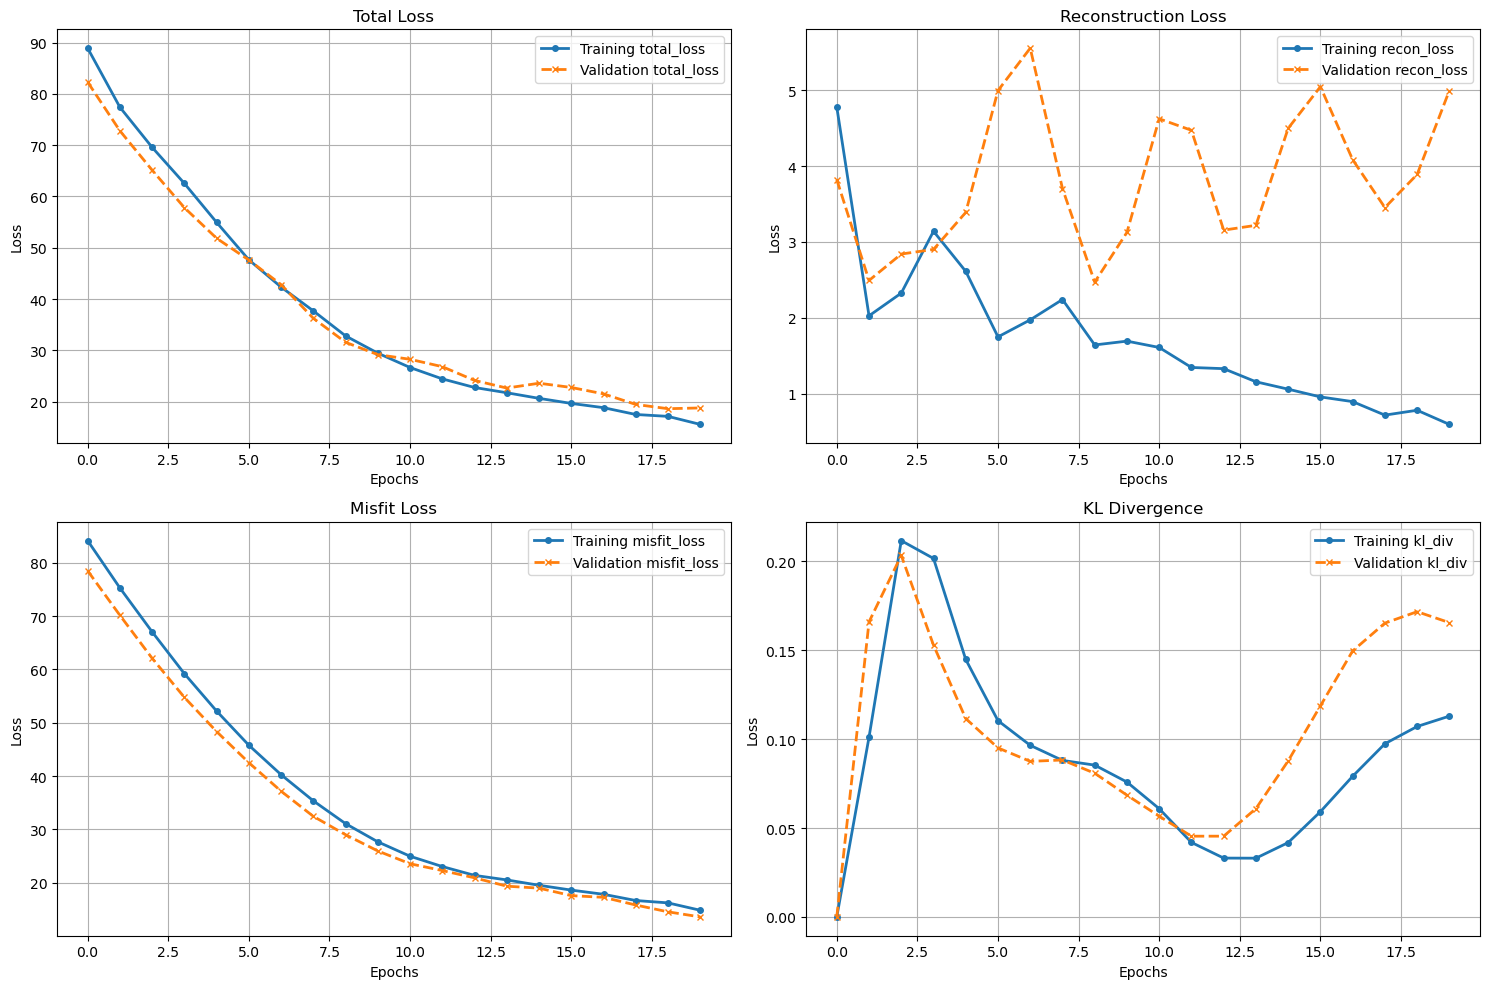

In [ ]:
network.plot_loss()

# Inference

In [ ]:
post = network.get_posterior(observed_data= observed_data, num_samples=10000)
post = theta_normalizer.inverse_transform(post)


In [ ]:
#gk_dist.plot_posterior(post)

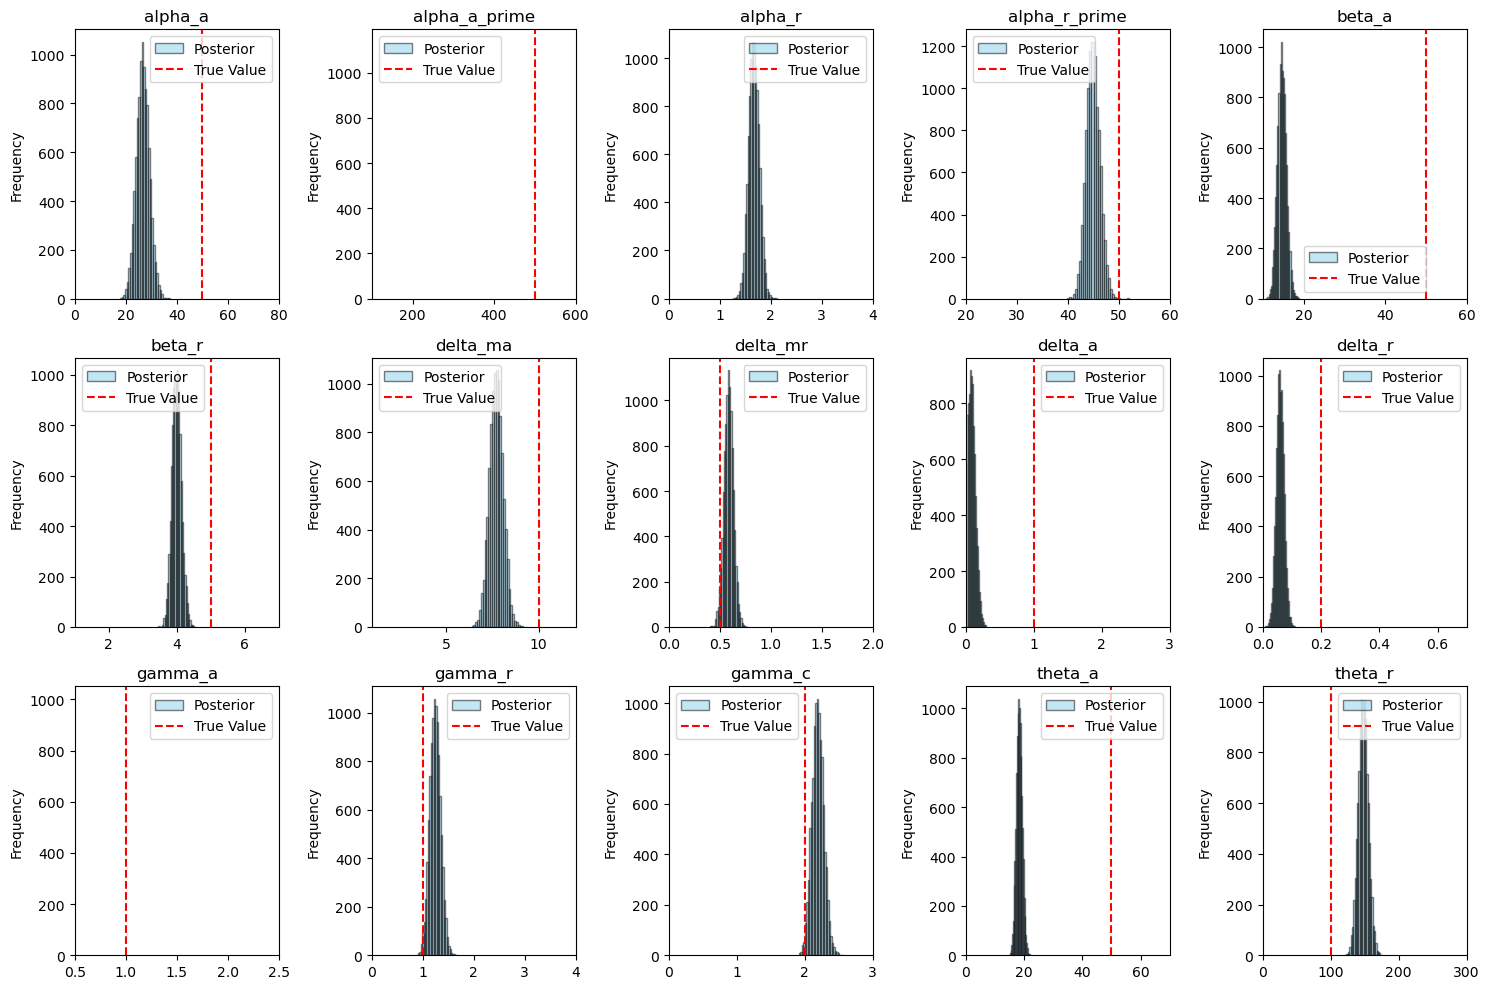

In [ ]:
villar.posterior_hist(post)